In [70]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import importlib
import os
from sklearn.metrics import confusion_matrix
import config
importlib.reload(config)
from config import BIN_SIZE, STRATIFY_BY, ANALYSIS_MODE
import joblib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import get_stable_pipeline, preprocess_data

In [71]:
# Configuration
MODEL_PATH = 'final_lasso_model.joblib'
FEATURES_PATH = 'model_features.joblib'
HOLDOUT_MATRIX_PATH = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/final_feature_matrix_gc_corrected_50000.tsv"
BIN_SIZE = 50000

print("--- Final Holdout Validation ---")

--- Final Holdout Validation ---


In [72]:
model = joblib.load(MODEL_PATH)

model_step = model.named_steps['stable_model']
c_wert = model_step.C
print(f"Der verwendete C-Wert ist: {c_wert}")


# Simple Pipeline
# c_best = model.named_steps['lasso_cv'].C_[0] 
# alle_cs = model.named_steps['lasso_cv'].Cs_
# print(f"Bester C-Wert aus CV: {c_best}")

Der verwendete C-Wert ist: 0.8685113737513525


In [73]:
# 1. Die gesamte Struktur anzeigen
print("Modell Struktur:")
print(model)

# 2. Nur das Modell innerhalb der Pipeline ansprechen (der letzte Schritt)
model_step = model.named_steps['stable_model']

# 3. Den C-Wert und andere Hyperparameter auslesen
print("\n--- Modell Parameter ---")
print(f"Gewählter C-Wert (c_1se): {model_step.C}")
print(f"Penalty (Lasso/Ridge):   {model_step.penalty}")
print(f"Solver:                  {model_step.solver}")

# 4. Falls du sehen willst, wie viele Koeffizienten NICHT null sind (Relevante Bins)
n_features = np.sum(model_step.coef_ != 0)
model_features = joblib.load('model_features.joblib')
print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")




# Simple Model

# cv_step = model.named_steps['lasso_cv']

# print("\n--- CV Modell Parameter ---")
# print(f"Bester C-Wert (optimal): {cv_step.C_[0]}") 
# print(f"Anzahl getesteter Cs:    {len(cv_step.Cs_)}")
# print(f"Penalty:                 {cv_step.penalty}")

# n_features = np.sum(cv_step.coef_ != 0)
# model_features = joblib.load('model_features.joblib')

# print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")
# mean_scores = np.mean(cv_step.scores_[1], axis=0) 
# best_score = np.max(mean_scores)
# print(f"Bester Mean CV AUC:     {best_score:.4f}")

needed_metrics = list(set([f.split('_chr')[0] for f in model_features]))
print(f"Metrics required by model: {needed_metrics}")

Modell Struktur:
Pipeline(steps=[('scaler', StandardScaler()),
                ('stable_model',
                 LogisticRegression(C=0.8685113737513525, max_iter=10000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

--- Modell Parameter ---
Gewählter C-Wert (c_1se): 0.8685113737513525
Penalty (Lasso/Ridge):   l1
Solver:                  liblinear
Anzahl relevanter Bins:  105 von 8520
Metrics required by model: ['stdev', 'mean']


In [74]:
# 3. Load Holdout Data
print("Loading holdout matrix...")
if not os.path.exists(HOLDOUT_MATRIX_PATH):
    print(f"ERROR: Holdout matrix not found at {HOLDOUT_MATRIX_PATH}")
    exit(1)

df_holdout = pd.read_csv(HOLDOUT_MATRIX_PATH, sep="\t")
df_holdout = df_holdout[~df_holdout["group"].isin(["duodenal", "esophageal"])]


Loading holdout matrix...


In [75]:
# 4. Prepare Holdout Features (Pivoting)
print("Formatting holdout features to match model structure...")
# Add bin_id (format chrom_start) like in your helper_functions
df_holdout["bin_id"] = df_holdout["chrom"] + "_" + df_holdout["start"].astype(str)

# Pivot the long-format holdout data into the wide format the model expects
X_holdout_raw = df_holdout.pivot(index="sample", columns="bin_id", values=needed_metrics)

# Flatten columns to match 'metric_chrom_start' (e.g., 'mean_chr1_900000')
X_holdout_raw.columns = [f"{m}_{bid}" for m, bid in X_holdout_raw.columns]

# IMPORTANT: Align columns with the model features (handle missing bins and order)
X_holdout = X_holdout_raw.reindex(columns=model_features, fill_value=0)
print(f"Feature alignment complete. Shape: {X_holdout.shape}")

Formatting holdout features to match model structure...
Feature alignment complete. Shape: (27, 8520)


In [76]:
missing = set(model_features) - set(X_holdout.columns)
print(len(missing))


0


In [77]:
import numpy as np
import pandas as pd

scaler = model.named_steps["scaler"]

# Z-Scores des Holdouts relativ zur Trainingsverteilung
Z = (X_holdout.values - scaler.mean_) / scaler.scale_

# 1) Wie extrem ist Holdout insgesamt?
absZ = np.abs(Z)
print("max |z|:", np.nanmax(absZ))
print("percentiles |z|:", np.nanpercentile(absZ, [50, 90, 95, 99, 99.9]))

# 2) Welche Features sind am stärksten "off"?
max_absZ_per_feature = np.nanmax(absZ, axis=0)
top_idx = np.argsort(max_absZ_per_feature)[::-1][:20]

top_shift = pd.Series(max_absZ_per_feature[top_idx], index=X_holdout.columns[top_idx])
display(top_shift)

# 3) Wie viele Werte sind extrem außerhalb?
print("fraction |z|>5:", np.nanmean(absZ > 5))
print("fraction |z|>10:", np.nanmean(absZ > 10))


max |z|: 46.29875345678282
percentiles |z|: [ 0.80104454  7.25525341  9.29201936 13.22762475 18.68119   ]


mean_chr2_20650000      46.298753
mean_chr9_124450000     43.325404
mean_chr7_150000        42.528426
mean_chr4_3200000       42.229796
mean_chr8_144300000     40.869821
mean_chr5_1150000       39.875418
mean_chr16_74400000     38.679678
mean_chr21_46150000     38.414177
mean_chr11_1550000      37.805461
mean_chr17_18600000     37.739693
mean_chr2_240850000     37.348784
mean_chr17_81100000     37.224762
mean_chr16_2000000      37.047560
mean_chr9_96900000      36.691201
mean_chr9_131250000     36.370965
mean_chr9_137050000     36.078897
mean_chr7_1650000       35.822209
mean_chr1_2500000       35.264532
mean_chr16_49850000     35.034524
mean_chr10_132350000    34.387037
dtype: float64

fraction |z|>5: 0.15436445835506868
fraction |z|>10: 0.03768040340810294


In [78]:
feat = "mean_chr2_20650000"

print("Train mean:", scaler.mean_[X_holdout.columns.get_loc(feat)])
print("Train std:", scaler.scale_[X_holdout.columns.get_loc(feat)])

print("Holdout mean:", X_holdout[feat].mean())
print("Holdout min/max:", X_holdout[feat].min(), X_holdout[feat].max())


Train mean: 165.8068704360409
Train std: 3.511823718619154
Holdout mean: 156.59288730399336
Holdout min/max: 3.2138099040104606 177.2473153594325


In [79]:
# 5. Extract Ground Truth (y_holdout)
# We use the 'group' column which contains the folder names (healthy, pancreatic, etc.)
group_info = df_holdout[['sample', 'group']].drop_duplicates().set_index('sample')
# 1 if cancer, 0 if healthy
y_holdout = (group_info.loc[X_holdout.index, "group"].str.lower() != "healthy").astype(int).values


In [80]:
# 6. Prediction
print(f"Running prediction on {len(X_holdout)} samples...")
probs = model.predict_proba(X_holdout)[:, 1]

Running prediction on 27 samples...


In [81]:
# 7. Evaluation (AUC Score)
auc_score = roc_auc_score(y_holdout, probs)
print(f"\n" + "="*40)
print(f"FINAL HOLDOUT AUC: {auc_score:.4f}")
print("="*40 + "\n")


FINAL HOLDOUT AUC: 0.4111



In [82]:
# 8. Save Results
output_dir = "holdout_preprocessing/results"
os.makedirs(output_dir, exist_ok=True)
results_df = pd.DataFrame({
    'sample': X_holdout.index,
    'prediction_score': probs,
    'true_label': y_holdout
})
results_df.to_csv(f"{output_dir}/holdout_validation_results.csv", index=False)


Detailed results and plots saved in 'holdout_preprocessing/'.


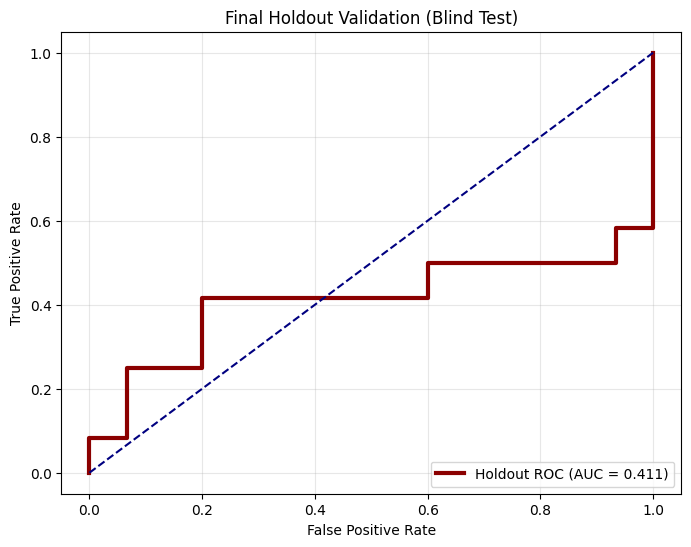

In [83]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=3, label=f'Holdout ROC (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Holdout Validation (Blind Test)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("holdout_preprocessing/plots/holdout_final_roc_joblib.png")
print("Detailed results and plots saved in 'holdout_preprocessing/'.")

In [84]:
# 5.5 DIAGNOSTIC: Check what's happening
print("="*80)
print("DIAGNOSTIC: Label & Prediction Analysis")
print("="*80)

preds = (probs > 0.5).astype(int)

print(f"\n1. Label Distribution:")
print(f"   0 (Healthy): {np.sum(y_holdout == 0)} samples")
print(f"   1 (Cancer):  {np.sum(y_holdout == 1)} samples")

print(f"\n2. Prediction Distribution:")
print(f"   0 (Predicted Healthy): {np.sum(preds == 0)} samples")
print(f"   1 (Predicted Cancer):  {np.sum(preds == 1)} samples")

print(f"\n3. Probability Statistics:")
print(f"   Min:    {probs.min():.4f}")
print(f"   Max:    {probs.max():.4f}")
print(f"   Mean:   {probs.mean():.4f}")
print(f"   Median: {np.median(probs):.4f}")

tn, fp, fn, tp = confusion_matrix(y_holdout, preds).ravel()
print(f"\n4. Confusion Matrix:")
print(f"   TP: {tp:2d}  FP: {fp:2d}")
print(f"   FN: {fn:2d}  TN: {tn:2d}")

print(f"\n5. Sample-by-Sample Breakdown:")
results_diag = pd.DataFrame({
    'sample': X_holdout.index,
    'group': group_info.loc[X_holdout.index, 'group'].values,
    'true_label': y_holdout,
    'prob_cancer': probs,
    'pred_label': preds
})
print(results_diag.sort_values('prob_cancer', ascending=False).to_string())

print(f"\n6. AUC Test - Check if labels are inverted:")
y_flipped = 1 - y_holdout
from sklearn.metrics import roc_auc_score
auc_flipped = roc_auc_score(y_flipped, probs)
print(f"   Current AUC:       {roc_auc_score(y_holdout, probs):.4f}")
print(f"   AUC with flipped labels: {auc_flipped:.4f}")
if auc_flipped > 0.8:
    print(f"   ⚠️  ALERT: Labels might be INVERTED! AUC improves to {auc_flipped:.4f}")

print("="*80)

DIAGNOSTIC: Label & Prediction Analysis

1. Label Distribution:
   0 (Healthy): 15 samples
   1 (Cancer):  12 samples

2. Prediction Distribution:
   0 (Predicted Healthy): 18 samples
   1 (Predicted Cancer):  9 samples

3. Probability Statistics:
   Min:    0.0000
   Max:    0.9990
   Mean:   0.3903
   Median: 0.2996

4. Confusion Matrix:
   TP:  5  FP:  4
   FN:  7  TN: 11

5. Sample-by-Sample Breakdown:
     sample       group  true_label   prob_cancer  pred_label
2   EE85726  colorectal           1  9.989857e-01           1
13  EE85842     healthy           0  9.691521e-01           1
22  EE87787    bileduct           1  9.524764e-01           1
21  EE87786    bileduct           1  9.386538e-01           1
7   EE85784     healthy           0  9.356056e-01           1
10  EE85795     healthy           0  9.036648e-01           1
23  EE87788    bileduct           1  5.786566e-01           1
24  EE87893     gastric           1  5.629582e-01           1
4   EE85757     healthy         

In [87]:
df_holdout[df_holdout["group"] =="pancreatic"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
76680,EE86244,pancreatic,chr1,18,115.917540,98.572760,47.462974,42.126549,181.470073,-0.510411,900000,950000,0.63236,chr1_900000
76681,EE86244,pancreatic,chr1,21,116.774404,99.618293,65.990639,38.105430,306.004381,-0.200328,1050000,1100000,0.62400,chr1_1050000
76682,EE86244,pancreatic,chr1,23,116.398701,109.618210,54.881767,44.692390,254.439142,-0.347350,1150000,1200000,0.59202,chr1_1150000
76683,EE86244,pancreatic,chr1,25,126.707891,142.402685,50.977465,32.045817,241.612680,-0.470818,1250000,1300000,0.60030,chr1_1250000
76684,EE86244,pancreatic,chr1,26,113.081272,111.115359,52.126409,38.493717,258.527309,-0.360830,1300000,1350000,0.64590,chr1_1300000
76685,EE86244,pancreatic,chr1,27,98.467783,91.629054,44.116532,38.969522,206.557757,-0.256151,1350000,1400000,0.56750,chr1_1350000
76686,EE86244,pancreatic,chr1,28,109.457122,94.625128,52.535289,39.979076,222.333913,-0.307723,1400000,1450000,0.57180,chr1_1400000
76687,EE86244,pancreatic,chr1,30,110.943408,99.912470,56.786951,34.024910,253.084812,-0.189870,1500000,1550000,0.59168,chr1_1500000
76688,EE86244,pancreatic,chr1,32,133.262063,146.059228,55.517271,35.059995,299.957351,-0.538920,1600000,1650000,0.60602,chr1_1600000
76689,EE86244,pancreatic,chr1,33,142.101939,159.724126,44.837255,45.875814,200.955934,-0.379836,1650000,1700000,0.52990,chr1_1650000


In [88]:
df_holdout[df_holdout["group"] =="gastric"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
115020,EE87893,gastric,chr1,18,161.573213,165.361049,23.345738,114.532721,230.420516,-0.008256,900000,950000,0.63236,chr1_900000
115021,EE87893,gastric,chr1,21,175.726416,172.772317,14.624693,151.674910,230.085779,0.149016,1050000,1100000,0.62400,chr1_1050000
115022,EE87893,gastric,chr1,23,166.962339,167.259091,16.194709,132.886289,206.104729,-0.213177,1150000,1200000,0.59202,chr1_1150000
115023,EE87893,gastric,chr1,25,170.710694,167.266540,19.469610,125.578608,226.615589,-0.447595,1250000,1300000,0.60030,chr1_1250000
115024,EE87893,gastric,chr1,26,167.719953,165.003636,16.883603,124.970099,211.285545,0.114930,1300000,1350000,0.64590,chr1_1300000
115025,EE87893,gastric,chr1,27,167.222737,168.155978,22.605078,108.636895,243.748981,-0.165592,1350000,1400000,0.56750,chr1_1350000
115026,EE87893,gastric,chr1,28,166.371864,163.703170,22.959345,110.063914,215.928150,0.038312,1400000,1450000,0.57180,chr1_1400000
115027,EE87893,gastric,chr1,30,164.480707,157.422020,20.340588,128.225414,206.757232,-0.259349,1500000,1550000,0.59168,chr1_1500000
115028,EE87893,gastric,chr1,32,161.917831,160.578892,16.863975,120.981187,202.352111,-0.161908,1600000,1650000,0.60602,chr1_1600000
115029,EE87893,gastric,chr1,33,151.167035,151.751750,21.275967,102.265583,191.147557,-0.682243,1650000,1700000,0.52990,chr1_1650000


In [89]:
df_holdout[df_holdout["group"] =="colorectal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
0,EE85723,colorectal,chr1,18,121.873988,84.653969,43.064116,27.104385,173.173973,-0.454357,900000,950000,0.63236,chr1_900000
1,EE85723,colorectal,chr1,21,123.076178,130.803106,9.496587,75.722503,141.645610,-0.346448,1050000,1100000,0.62400,chr1_1050000
2,EE85723,colorectal,chr1,23,106.530763,116.875511,28.045713,28.201923,147.211087,-0.410098,1150000,1200000,0.59202,chr1_1150000
3,EE85723,colorectal,chr1,25,131.500618,138.138259,13.874622,83.785539,153.361461,-0.344989,1250000,1300000,0.60030,chr1_1250000
4,EE85723,colorectal,chr1,26,104.961001,111.367002,17.675930,45.812068,137.337808,-0.462196,1300000,1350000,0.64590,chr1_1300000
5,EE85723,colorectal,chr1,27,116.360314,121.523693,73.653040,14.531443,196.506616,-0.267057,1350000,1400000,0.56750,chr1_1350000
6,EE85723,colorectal,chr1,28,119.692241,115.467310,43.787627,21.215207,179.271765,-0.466075,1400000,1450000,0.57180,chr1_1400000
7,EE85723,colorectal,chr1,30,135.594707,127.507399,18.049147,81.933475,162.816935,-0.371662,1500000,1550000,0.59168,chr1_1500000
8,EE85723,colorectal,chr1,32,152.072744,145.971864,17.270324,96.188341,175.389893,-0.441496,1600000,1650000,0.60602,chr1_1600000
9,EE85723,colorectal,chr1,33,100.641251,85.121112,44.999032,3.708448,150.845374,-0.240760,1650000,1700000,0.52990,chr1_1650000


In [90]:
df_holdout[df_holdout["group"] =="duodenal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id


In [91]:
df_holdout[df_holdout["group"] =="esophageal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
